# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import model_selection

import datetime

plt.style.use('ggplot')

# Dataset Import

In [2]:
data_file = 'bmw_pricing_v2.csv'

In [3]:
original_df = pd.read_csv(data_file)

In [4]:
original_df.head()

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               4842 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4831 non-null   object 
 7   tipo_coche                   4834 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4841 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  4839 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [6]:
original_df.isnull().sum()

marca                           2
modelo                          3
km                              2
potencia                        1
fecha_registro                  1
tipo_gasolina                   5
color                          12
tipo_coche                      9
volante_regulable               4
aire_acondicionado              2
camara_trasera                  2
asientos_traseros_plegables     4
elevalunas_electrico            2
bluetooth                       4
gps                             0
alerta_lim_velocidad            2
precio                          6
fecha_venta                     1
dtype: int64

# Preguntas sobre el dataset

In [7]:
# Listado de vehículos agrupados por modelo y tipo de gasolina
original_df.groupby(['modelo', 'tipo_gasolina'])[['precio']].mean()

precio
modelo         tipo_gasolina              
 Active Tourer diesel         19000.000000
114            diesel         10460.000000
               petrol         12700.000000
116            diesel          9757.522124
               petrol          7805.263158
...                                    ...
X6 M           petrol         82400.000000
Z4             petrol          9500.000000
i3             electro        20966.666667
               hybrid_petrol  21266.666667
i8             hybrid_petrol  95200.000000

[109 rows x 1 columns]

In [8]:
# Cantidad de vehículos con potencia superior a 150, convertible y con volante regulable
len(original_df[(original_df['potencia'] > 150) & (original_df['tipo_coche'] == 'convertible') & (original_df['volante_regulable'] == True)])

9

In [9]:
# Fecha de registro superior a la fecha de venta?

serie_incremento_fechas = (pd.to_datetime(original_df['fecha_venta']) - pd.to_datetime(original_df['fecha_registro'])).dt.days
valores_negativos = serie_incremento_fechas[serie_incremento_fechas < 0].index
display(original_df.loc[valores_negativos, :])

# Precio medio de estos coches

print(f'Precio medio de estos coches: {original_df.loc[valores_negativos, "precio"].mean():.2f}')
print(f'Precio medio global: {original_df["precio"].mean():.2f}')

# Parece que son más baratos que la media global

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
42,BMW,330,142483.0,180.0,2012-01-01,diesel,blue,convertible,True,True,False,False,True,False,True,True,15800.0,2007-08-01
100,BMW,320,342768.0,135.0,2011-12-01,diesel,black,coupe,False,True,False,False,True,False,True,False,8200.0,2010-04-01
180,BMW,320,181052.0,120.0,2014-10-01,diesel,black,estate,False,True,False,False,False,False,True,True,11500.0,2009-04-01
256,BMW,316,201102.0,85.0,2013-12-01,diesel,black,estate,True,False,False,False,False,False,True,False,8800.0,2008-06-01


Precio medio de estos coches: 11075.00
Precio medio global: 15831.92


In [10]:
# Precio medio de los vehículos con aire acondicionad
round(original_df[original_df['aire_acondicionado'] == True]['precio'].mean(), 2)

# Parece que son un poco más caros respecto la media global

16998.12

In [11]:
# Precio medio por color
original_df.groupby(by = ['color'])[['precio']].agg(['mean', 'count']).sort_values(by = ('precio', 'mean'), ascending = False)

# El color verde es significativamente más barato que el resto, y no se tiene una sola muestra (no parece ser un outlier)
# El color naranja es el más caro (hay pocas muestras) seguido del blanco.

precio      
                mean count
color                     
orange  18866.666667     6
white   17314.365672   536
red     16568.627451    51
black   16178.479460  1631
beige   15817.073171    41
grey    15619.914530  1170
brown   15367.741935   341
blue    15137.784091   704
silver  14826.299694   327
green    7200.000000    18

# Generación del modelo predictivo

## EDA + Data cleaning

### Target

In [12]:
# Se trabaja con el format_df para empezar a manipular el dataset
format_df = original_df.copy()

In [13]:
# El target es el precio. Es una variable numérica, así que es correcta tal y como está
target = 'precio'

In [14]:
# Se dropean los valores nulos del target, ya que són muy pocos (6 de 4843)
format_df.dropna(subset = [target], inplace = True)

In [15]:
# Se resetea el índice
format_df.reset_index(drop = True, inplace = True)

In [16]:
# Precio medio para tenerlo como referencia
format_df[target].mean()

15831.920611949556

<AxesSubplot:>

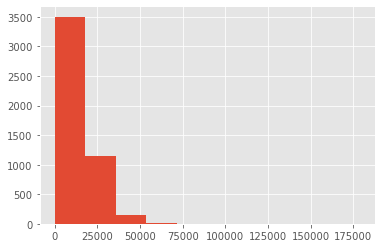

In [17]:
# Distribución del precio. Se ve claramente una distribución right-skewed, por lo que se aplicará una función logarítmica
format_df[target].hist()

In [18]:
# Solo 32 coches tienen un precio superior a 50.000
len(format_df[format_df[target] > 50000])

32

### Columna Marca

In [19]:
# Como se trata de un dataset de BMW, se intuye que todos los coches serán de la misma marca
format_df['marca'].unique()

array(['BMW', nan], dtype=object)

In [20]:
# Se borra la columna porque, aunque tenga algunos nulos, todos los coches son de la misma marca
format_df.drop(columns = 'marca', inplace = True)

### Columnas de fecha

In [21]:
# Se detecta que las siguientes columnas contienen fechas:
glob_list_date = [column for column in format_df.columns if 'fecha' in column]

In [22]:
# Nulos de las columnas de fecha:
format_df[glob_list_date].isnull().sum()

fecha_registro    1
fecha_venta       1
dtype: int64

In [23]:
format_df[format_df[glob_list_date[0]].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
197,318,158853.0,100.0,NaN,diesel,black,estate,True,False,False,False,False,False,True,False,10900.0,2018-06-01


In [24]:
format_df[format_df[glob_list_date[1]].isnull()]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
588,525,269290.0,120.0,2005-06-01,diesel,silver,estate,True,False,True,False,False,False,True,True,4200.0,NaN


In [25]:
# Se pasan las columnas a datetime
for column in glob_list_date:
    format_df[column] = pd.to_datetime(format_df[column])

<AxesSubplot:>

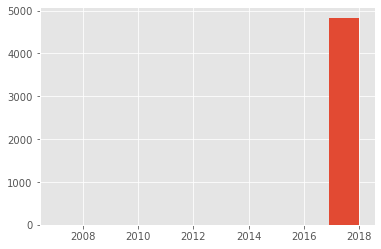

In [26]:
# Para la fecha_venta, se detecta que casi todos las fechas son el año 2018
format_df['fecha_venta'].dt.year.hist()

In [27]:
# Se comprueba que solo hay 4 coches con una fecha inferior a 2018. 
# Además estos coches tienen una fecha de registro superior a la fecha de venta, hecho muy anormal
format_df[format_df['fecha_venta'].dt.year < 2018]

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
42,330,142483.0,180.0,2012-01-01,diesel,blue,convertible,True,True,False,False,True,False,True,True,15800.0,2007-08-01
100,320,342768.0,135.0,2011-12-01,diesel,black,coupe,False,True,False,False,True,False,True,False,8200.0,2010-04-01
179,320,181052.0,120.0,2014-10-01,diesel,black,estate,False,True,False,False,False,False,True,True,11500.0,2009-04-01
255,316,201102.0,85.0,2013-12-01,diesel,black,estate,True,False,False,False,False,False,True,False,8800.0,2008-06-01


In [28]:
# Se cambiará el año de estos coches a 2018, ya que se considera un error (es muy estraño que solo 4 coches tengan un año inferior)
# De todas maneras, en un contexto real se tendría que consultar a negocio esta anomalía
idx_venta_no_2018 = format_df[format_df['fecha_venta'].dt.year < 2018].index
format_df.loc[idx_venta_no_2018, 'fecha_venta'] = format_df.loc[idx_venta_no_2018, 'fecha_venta'].apply(lambda x: x.replace(year = 2018))

Para rellenar los nulos de la fecha_venta, se calcula la media del mes de venta y se le asigna el año 2018 y el día 1, ya que el resto de variables son así

In [29]:
month_mean_venta = int(round(format_df['fecha_venta'].dt.month.mean(), 0))

In [30]:
format_df['fecha_venta'].fillna(datetime.datetime(year = 2018, month = month_mean_venta, day = 1), inplace = True)

In [31]:
format_df['fecha_venta'].isnull().sum()

0

Para rellenar los nulos de la fecha_registro, se decide calcular el tiempo medio entre la fecha de venta y la fecha de registro e imputar el valor que falta acorde al número calculado

In [32]:
# Se analiza la muestra del tiempo entre registro y venta
date_series = (format_df['fecha_venta'] - format_df['fecha_registro']).dt.days

In [33]:
# Parece que hay algún valor nulo y algún outlier
date_series.describe()

count     4836.000000
mean      1984.254963
std        927.862801
min        215.000000
25%       1489.000000
50%       1765.000000
75%       2130.000000
max      10258.000000
dtype: float64

<AxesSubplot:>

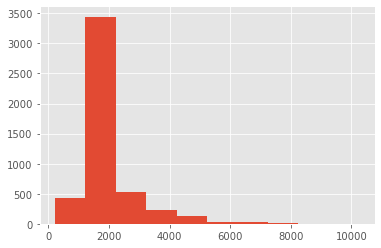

In [34]:
date_series.hist()

In [35]:
# Porcentaje de valores con fecha de venta superior a 8000 días a la fecha de registro
len(date_series[date_series > 8000]) / len(date_series) * 100

0.08269588587967748

In [36]:
# Se decide hacer la media con el 99% de los datos quitando outliers de valor muy elevado
cuantil_alto = np.nanquantile(date_series, 0.99)

In [37]:
# Se calcula la media y se pasa a valor entero redondeado
media_date_series = int(round(date_series[date_series < cuantil_alto].mean(), 0))

In [38]:
media_date_series

1935

In [39]:
# Se rellenan los valores nulos de fecha registro
format_df['fecha_registro'].fillna(format_df['fecha_venta'] - datetime.timedelta(days = media_date_series), inplace = True)

Como el modelo no acepta columnas datetime, se extrae toda la informació que se considera útil de las fechas en formato número. Concretamente:

In [40]:
# Se calcula el tiempo entre venta y registro, en días
format_df['dias_venta_registro'] = (format_df['fecha_venta'] - format_df['fecha_registro']).dt.days

In [41]:
# En la exploración inicial se detecta que los días de la fecha siempre son el primero de mes.
# La excepción es debido a valor nulo imputado a posteriori
format_df['fecha_registro'].dt.day.value_counts()

1     4836
12       1
Name: fecha_registro, dtype: int64

In [42]:
# Se extrae el año y el mes. El día no se extrae debido a que no hay varianza
for column in glob_list_date:
    format_df[column + '_año'] = format_df[column].dt.year
    format_df[column + '_mes'] = format_df[column].dt.month

In [43]:
format_df.head()

,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,...,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,dias_venta_registro,fecha_registro_año,fecha_registro_mes,fecha_venta_año,fecha_venta_mes
0,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,...,True,True,False,11300.0,2018-01-01,2161,2012,2,2018,1
1,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,...,True,True,True,69700.0,2018-02-01,671,2016,4,2018,2
2,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,...,False,True,False,10200.0,2018-02-01,2132,2012,4,2018,2
3,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,...,True,True,True,25100.0,2018-02-01,1311,2014,7,2018,2
4,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,...,True,True,True,33400.0,2018-04-01,1217,2014,12,2018,4


In [44]:
# Se eliminan las columnas datetime al haber sido ya tratadas
format_df.drop(columns = glob_list_date, inplace = True)

In [45]:
# También se elimina la columna de fecha_venta_año, ya que no tiene varianza (todos los valores son 2018)
format_df.drop(columns = 'fecha_venta_año', inplace = True)

### Columnas numéricas

#### EDA

In [46]:
# Lista de variables numéricas
glob_list_num = list(format_df.describe().drop(columns = target).columns)

In [47]:
# Se podría plantear la eliminiación de la variablefecha_venta_año por poca varianza
format_df[glob_list_num].describe().T

,count,mean,std,min,25%,50%,75%,max
km,4835.0,140966.371251,60220.786757,-64.0,102870.0,141068.0,175243.5,1000376.0
potencia,4836.0,128.995037,39.011169,0.0,100.0,120.0,135.0,423.0
dias_venta_registro,4837.0,1984.244780,927.767134,215.0,1489.0,1765.0,2130.0,10258.0
fecha_registro_año,4837.0,2012.466405,2.528326,1990.0,2012.0,2013.0,2014.0,2017.0
fecha_registro_mes,4837.0,6.129419,3.316281,1.0,3.0,6.0,9.0,12.0
fecha_venta_mes,4837.0,4.929502,2.157419,1.0,3.0,5.0,7.0,9.0


In [48]:
# Función para plottear la relación entre las variables numéricas
def round_up(num, div):
    return num // div + (num % div > 0)

def relacion_num_target(df, num_vars, target):
    plt.subplots(figsize = (20, 30))
    for i, column in enumerate(num_vars):
        plt.subplot(round_up(len(num_vars), 2), 2, i + 1)
        sns.scatterplot(data = df[[column, target]], x = column, y = target)
        plt.title(f'Relación entre {column} y {target}')
    plt.show()

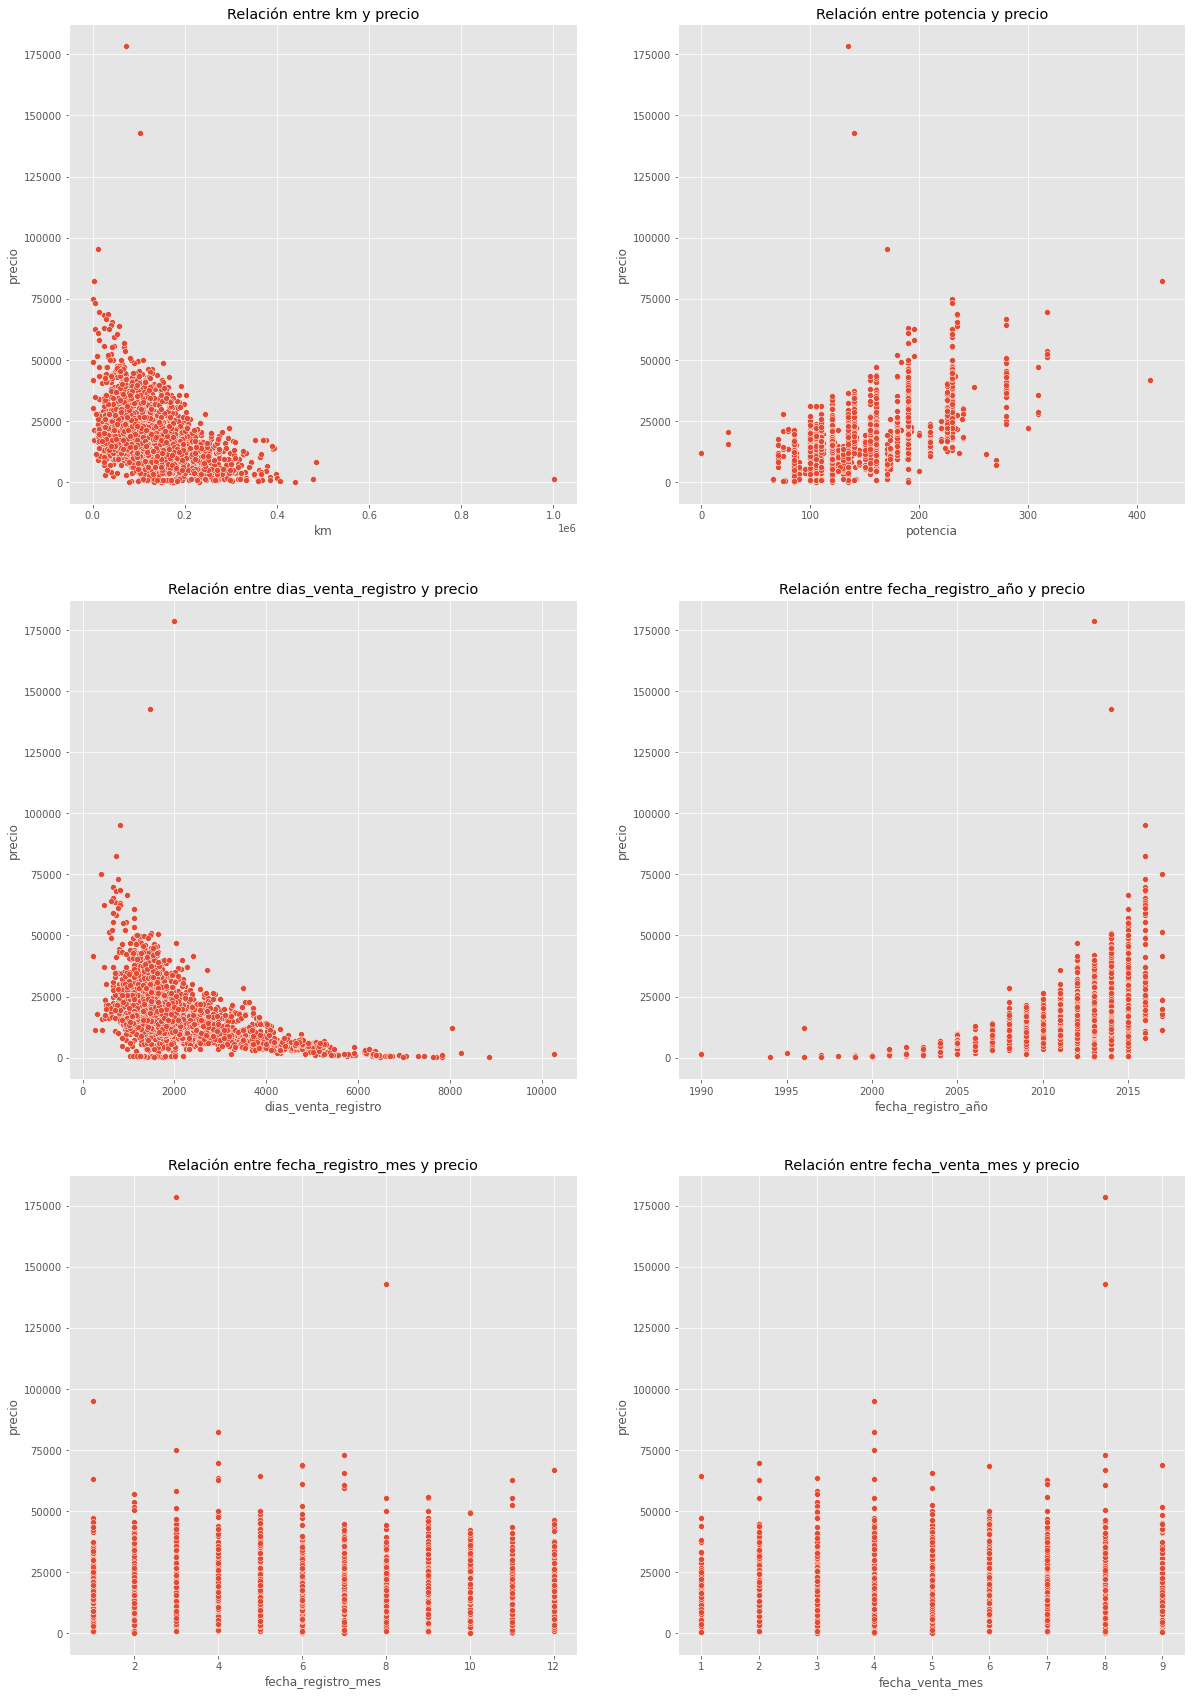

In [49]:
# Variables que parecen ser buenas predictoras: km, potencia, dias entre venta y registro y año de registro
relacion_num_target(format_df, glob_list_num, target)

In [50]:
# Con la matriz de correlación podemos determinar lo dicho anteriormente:
format_df[glob_list_num + [target]].corr().style.background_gradient('coolwarm')

,km,potencia,dias_venta_registro,fecha_registro_año,fecha_registro_mes,fecha_venta_mes,precio
km,1.000000,-0.050539,0.507026,-0.507520,-0.017273,-0.000166,-0.410189
potencia,-0.050539,1.000000,-0.084138,0.082588,-0.000582,-0.028549,0.639254
dias_venta_registro,0.507026,-0.084138,1.000000,-0.991441,-0.039718,0.125388,-0.445520
fecha_registro_año,-0.507520,0.082588,-0.991441,1.000000,-0.070533,-0.053299,0.450314
fecha_registro_mes,-0.017273,-0.000582,-0.039718,-0.070533,1.000000,-0.016384,-0.016071
fecha_venta_mes,-0.000166,-0.028549,0.125388,-0.053299,-0.016384,1.000000,0.012825
precio,-0.410189,0.639254,-0.445520,0.450314,-0.016071,0.012825,1.000000


En primer lugar, se confirma con la matriz de correlación que las variables más relacionadas con el target son:

- km
- potencia
- dias_venta_registro
- fecha_registro_años

Además, se puede visualizar la relación entre atributos numéricos. Destaca lo siguiente:

- km está relacionado con dias_venta_registro. Tiene sentido ya que se intuye que el coche estará más usado si han pasado más días entre los días de venta y registro.
- La variable dias_venta_registro está altamente correlacionada con fecha_registro_año. Esta última se eliminará en la parte de limpieza de datos

Adicionalmente, en caso de aplicar un modelo de regresión lineal, probablemente ayudaría a aplicar el logaritmo a dias_venta_registro, ya que parece tener cierta relación no lineal. Tambíen se podrían transformar los nulos a 0, ya que son solo 4 valores y no tiene mucho sentido que sea negativo

#### Data cleaning

In [51]:
# Se elimina la columna de fecha_registro_año. La de fecha_venta_año se mantiene
format_df.drop(columns = 'fecha_registro_año', inplace = True)

In [52]:
# Se recalcula la lista de numéricas
glob_list_num = list(format_df.describe().drop(columns = target).columns)

In [53]:
# Se tienen valores nulos en km y potencia
format_df[glob_list_num].isnull().sum()

km                     2
potencia               1
dias_venta_registro    0
fecha_registro_mes     0
fecha_venta_mes        0
dtype: int64

In [54]:
# Se asigna el kilometraje del coche en función de los días entre venta y registro mediante un modelo lineal
# Anteriormente ya se ha visto que están correlacionadas
train_sample_km = format_df[['dias_venta_registro', 'km']].dropna()
model_km = LinearRegression()
model_km.fit(np.array(train_sample_km['dias_venta_registro']).reshape(-1, 1), np.array(train_sample_km['km']))
null_values = format_df[format_df['km'].isnull()].index
format_df.loc[null_values, 'km'] = model_km.predict(np.array(format_df.loc[null_values, 'dias_venta_registro']).reshape(-1, 1))

In [55]:
# Se asigna la potencia restante del coche a partir del modelo y el tipo de gasolina
format_df[format_df['potencia'].isnull()]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
180,525,106054.0,NaN,diesel,black,estate,False,True,False,False,False,False,True,True,18700.0,1400,5,3


In [56]:
diesel_525 = format_df.groupby(['modelo', 'tipo_gasolina']).get_group(('525', 'diesel'))

In [57]:
diesel_525['potencia'].describe()

count    180.000000
mean     150.805556
std       15.661966
min       85.000000
25%      150.000000
50%      155.000000
75%      160.000000
max      160.000000
Name: potencia, dtype: float64

In [58]:
# Se decide asignar la potencia media de este subgrupo
format_df['potencia'].fillna(round(diesel_525['potencia'].mean(), 0), inplace = True)

In [59]:
# También se detecta un coche con potencia 0, cosa quee es imposible
format_df[format_df['potencia'] == 0]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
3759,X1,81770.0,0.0,diesel,white,suv,False,False,False,False,False,False,False,False,11700.0,1247,10,3


In [60]:
# Se sigue el mismo procedimiento
diesel_x1 = format_df.groupby(['modelo', 'tipo_gasolina']).get_group(('X1', 'diesel'))

In [61]:
diesel_x1['potencia'].describe()

count    272.000000
mean     109.768382
std       19.012950
min        0.000000
25%      100.000000
50%      105.000000
75%      120.000000
max      160.000000
Name: potencia, dtype: float64

In [62]:
format_df.loc[3759, 'potencia'] = round(diesel_x1['potencia'].mean(), 0)

In [63]:
# En el caso de los km, existen coches con kilometraje negativo, cosa que también es imposible
format_df[format_df['km'] <= 0]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
2932,640 Gran Coupé,-64.0,230.0,diesel,black,sedan,True,True,False,True,False,False,True,True,75000.0,396,3,4


In [64]:
# El coche en cuestión tiene muy pocos días entre venta y registro, por lo que se le asignará el valor mínimo de km
# del dataset excluyendo este negativo
idx_km_neg = format_df[format_df['km'] <= 0].index
format_df.loc[idx_km_neg, 'km'] = format_df['km'].drop(idx_km_neg).min()

In [65]:
format_df.head()

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
0,118,140411.0,100.0,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2161,2,1
1,M4,13929.0,317.0,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,671,4,2
2,320,183297.0,120.0,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2132,4,2
3,420,128035.0,135.0,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,1311,7,2
4,425,97097.0,160.0,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,1217,12,4


In [66]:
format_df[glob_list_num].isnull().sum()

km                     0
potencia               0
dias_venta_registro    0
fecha_registro_mes     0
fecha_venta_mes        0
dtype: int64

### Columnas categóricas

#### EDA

In [67]:
glob_list_bool = [column for column in format_df.columns if format_df[column].nunique() == 2]

In [68]:
# Proporción de cada variable booleana. Pocos coches sin bluetooth. El resto no está muy desbalanceado
bool_prop_list = []
for column in glob_list_bool:
    bool_prop_list.append(format_df[column].value_counts(normalize = True))
pd.DataFrame(bool_prop_list)

,True,False
volante_regulable,0.549969,0.450031
aire_acondicionado,0.792554,0.207446
camara_trasera,0.201448,0.798552
asientos_traseros_plegables,0.199048,0.800952
elevalunas_electrico,0.460393,0.539607
bluetooth,0.241465,0.758535
gps,0.931983,0.068017
alerta_lim_velocidad,0.540848,0.459152


In [69]:
def violinplot_bool(df, bool_vars, target):
    plt.subplots(figsize = (20, 30))
    for i, column in enumerate(bool_vars):
        plt.subplot(round_up(len(bool_vars), 2), 2, i + 1)
        sns.violinplot(data = df[[column, target]], x = column, y = target)
        plt.title(f'Relación entre {column} y {target}')
    plt.show()

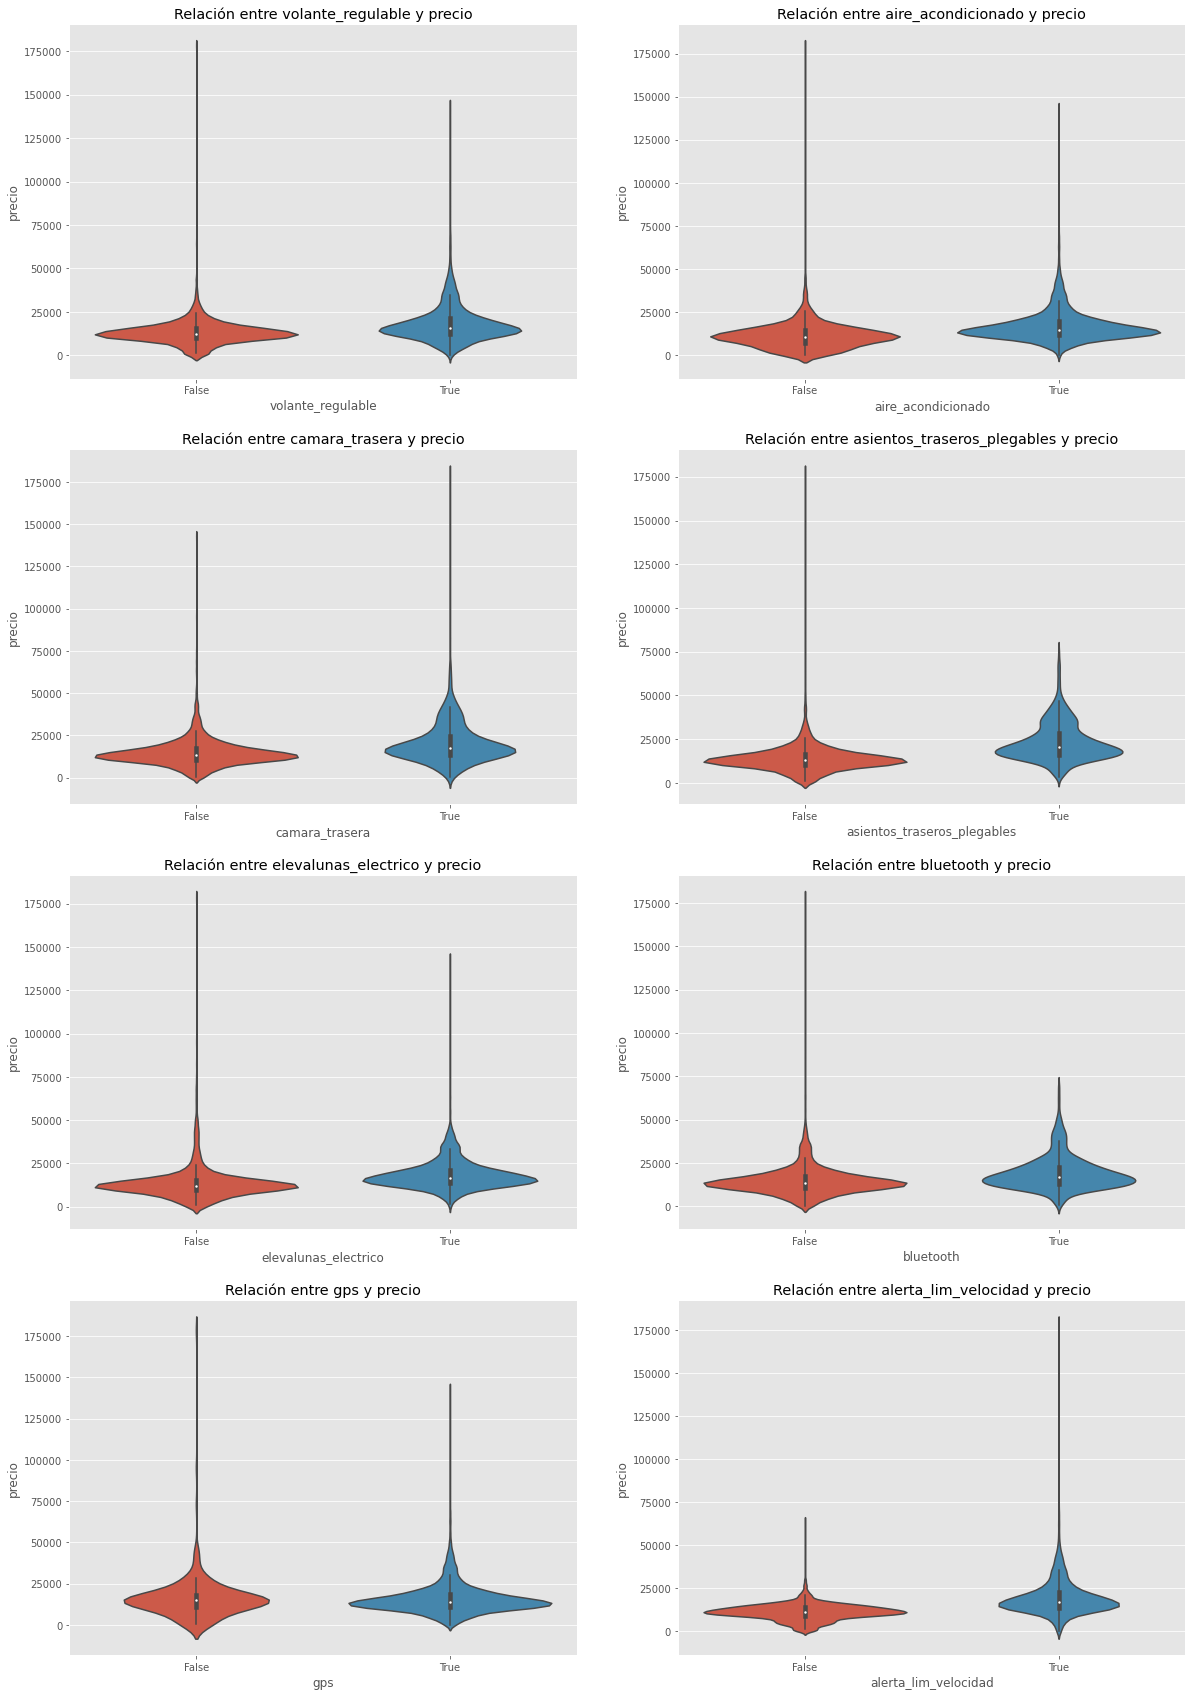

In [70]:
violinplot_bool(format_df, glob_list_bool, target)

En todos los casos excepto en la variable gps, si el atributo está en True, es decir, si se dispone de este accesorio, el precio parece ser un poco superior, lo cual es totalmente lógico (a más extras, más caro!).

Los que parecen tener más impacto son:

- camara_trasera
- asientos_traseros_plegables
- aleta_lim_velocidad

En el caso del gps, puede ser que no se vea mucha diferencia entre tenerlo o no porque se disponen de pocas muestras que no lo tengan.

In [71]:
# Resto de variables categóricas
glob_list_cat = list(set(format_df.describe(include = 'O').columns) - set(glob_list_bool))

In [72]:
# Para las categóricas con pocas categorías, se visualizan datos interesantes
def report_cat(df, cat_var, target):
    '''
    Se hace un report de la variable categórica con información interesante, 
    los nulos se agrupan bajo la etiqueta Other
    '''
    df_copy = df[cat_var + [target]].copy()

    for column in cat_var:

        if df_copy[column].nunique() > 11:
            less_freq_cat = df_copy[column].value_counts().iloc[10:].index
            df_copy[column] = df_copy[column].apply(lambda x: 'others' if x in less_freq_cat else x)

        report_df = df_copy[[column, target]].pivot_table(values = target, index = column, aggfunc = [len, np.mean,])
        report_df.columns = [x[0] + ' ' + x[1] for x in report_df.columns]

        report_df[f'proportion {target}'] = report_df[f'len {target}'] / report_df[f'len {target}'].sum() * 100 
        report_df = report_df[[f'len {target}', f'proportion {target}', f'mean {target}']]
        
        display(report_df.round(2).sort_values(by = f'mean {target}', ascending = False))

In [73]:
report_cat(format_df, glob_list_cat, target)

,len precio,proportion precio,mean precio
tipo_gasolina,,,
hybrid_petrol,8.0,0.17,37575.00
electro,3.0,0.06,20966.67
diesel,4625.0,95.72,15859.26
petrol,191.0,3.95,14398.43
Diesel,5.0,0.10,13960.00


,len precio,proportion precio,mean precio
modelo,,,
X5,231.0,4.78,30570.13
others,1009.0,20.87,20753.72
530,157.0,3.25,19826.11
X3,438.0,9.06,18175.80
520,632.0,13.07,15713.29
525,184.0,3.81,15363.04
X1,274.0,5.67,12691.97
320,750.0,15.52,12173.07
318,567.0,11.73,10982.19


,len precio,proportion precio,mean precio
tipo_coche,,,
coupe,103.0,2.13,22169.90
suv,1057.0,21.89,21500.47
convertible,47.0,0.97,17136.17
sedan,1167.0,24.17,16021.94
van,43.0,0.89,14323.26
hatchback,699.0,14.48,13289.41
estate,1599.0,33.12,13126.33
subcompact,113.0,2.34,9687.61


,len precio,proportion precio,mean precio
color,,,
orange,6.0,0.12,18866.67
white,536.0,11.11,17314.37
red,51.0,1.06,16568.63
black,1631.0,33.80,16178.48
beige,41.0,0.85,15817.07
grey,1170.0,24.25,15619.91
brown,341.0,7.07,15367.74
blue,704.0,14.59,15137.78
silver,327.0,6.78,14826.30


In [74]:
# Se detecta que existen coches diesel con la primera letra en mayúscula, hecho que ensucia la muestra. Para arreglarlo:
format_df['tipo_gasolina'] = format_df['tipo_gasolina'].str.lower()

In [75]:
format_df['tipo_gasolina'].unique()

array(['diesel', 'petrol', nan, 'hybrid_petrol', 'electro'], dtype=object)

In [76]:
# Análisis básico de cada etiqueta de cada atributo categórico
report_cat(format_df, glob_list_cat, target)

,len precio,proportion precio,mean precio
tipo_gasolina,,,
hybrid_petrol,8.0,0.17,37575.00
electro,3.0,0.06,20966.67
diesel,4630.0,95.82,15857.21
petrol,191.0,3.95,14398.43


,len precio,proportion precio,mean precio
modelo,,,
X5,231.0,4.78,30570.13
others,1009.0,20.87,20753.72
530,157.0,3.25,19826.11
X3,438.0,9.06,18175.80
520,632.0,13.07,15713.29
525,184.0,3.81,15363.04
X1,274.0,5.67,12691.97
320,750.0,15.52,12173.07
318,567.0,11.73,10982.19


,len precio,proportion precio,mean precio
tipo_coche,,,
coupe,103.0,2.13,22169.90
suv,1057.0,21.89,21500.47
convertible,47.0,0.97,17136.17
sedan,1167.0,24.17,16021.94
van,43.0,0.89,14323.26
hatchback,699.0,14.48,13289.41
estate,1599.0,33.12,13126.33
subcompact,113.0,2.34,9687.61


,len precio,proportion precio,mean precio
color,,,
orange,6.0,0.12,18866.67
white,536.0,11.11,17314.37
red,51.0,1.06,16568.63
black,1631.0,33.80,16178.48
beige,41.0,0.85,15817.07
grey,1170.0,24.25,15619.91
brown,341.0,7.07,15367.74
blue,704.0,14.59,15137.78
silver,327.0,6.78,14826.30


In [77]:
def boxenplot_cat(df, cat_var, target):
    plt.subplots(figsize = (20, 30))
    for i, column in enumerate(cat_var):
        df_copy = df[[column, target]].copy()
        if df_copy[column].nunique() > 11:
            less_freq_cat = df_copy[column].value_counts().iloc[10:].index
            df_copy[column] = df_copy[column].apply(lambda x: 'others' if x in less_freq_cat else x)
        plt.subplot(len(cat_var), 1, i + 1)
        sns.boxenplot(data = df_copy, x = column, y = target)
        plt.title(f'Relación entre {column} y {target}')
    plt.show()

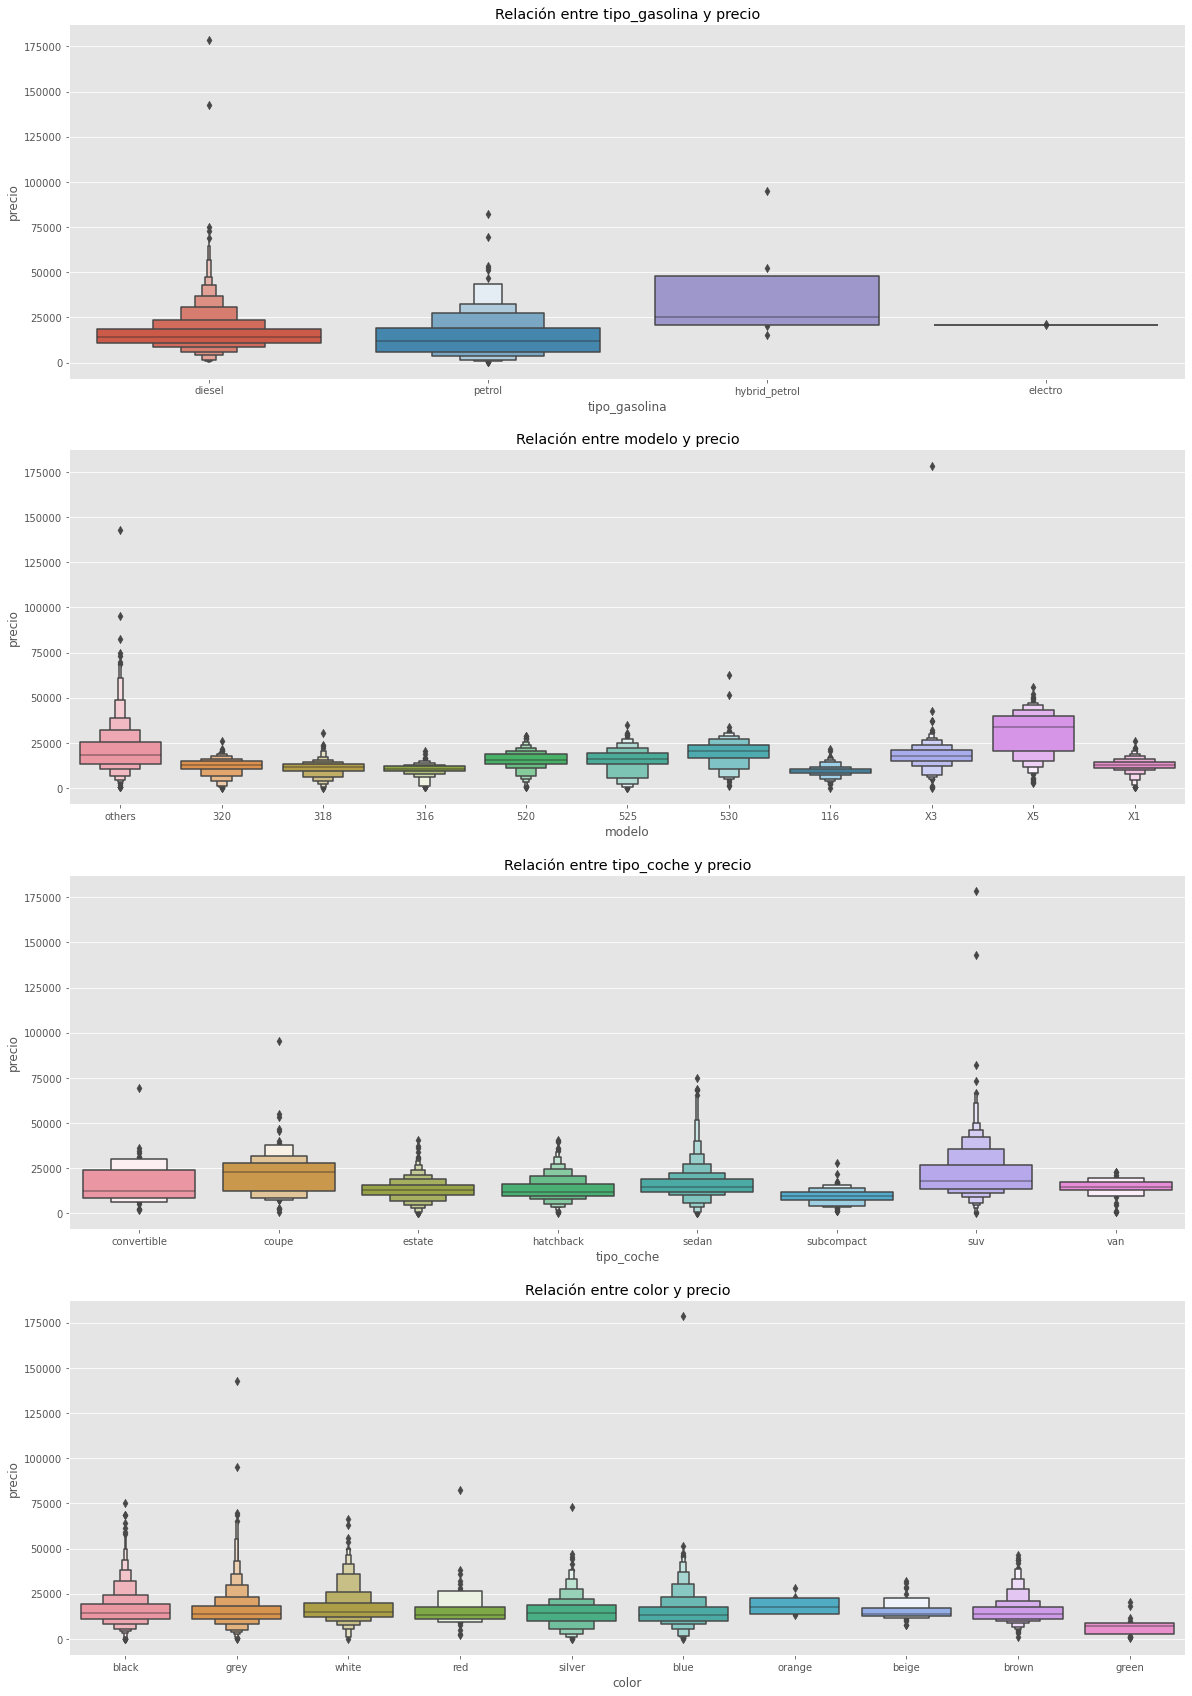

In [78]:
boxenplot_cat(format_df, glob_list_cat, target)

- tipo_coche: existen bastantes muestras de todos los tipos de coche, sin ninguna etiqueta con claramente pocas observaciones. Parece que los SUVs son el tipo de coche más caro, y los sedan también tiene observaciones con precio alto (parte alta del boxenplot muy estirada). En el casod de los coupé hay más variabilidad (tiene un boxenplot muy cuadrado) pero también tiene un precio bastante elevado (etiqueta con la media del precio más elevada). Finalmente, la etiqueta con un precio más bajo es el sub-compact.

- color: hay una etiqueta con un precio claramente más bajo que el resto: es el color verde. El resto de colores no parecen tener diferencias muy claras: si bien es verdad el color naranja tiene una media bastante elevada, tiene muy pocas observaciones (6). El color blanco podría tener una tendencia más a la alza a nivel de precio, pero tampoco es muy claro.

- tipo_gasolina: hay claramente muchísimas muestras de diesel. Parece que los coches híbridos tienen un precio más elevado.

- modelo: el modelo que claramente es el más caro es el x5. Por contra, el 116 parece ser el más barato. La categoría others parece tenir una gran variabilidad, lo que es comprensible ya que abarca varios modelos distintos.

#### Data cleaning

##### Imputación de nulos

In [79]:
# En primer lugar, se intuye una posible correlación entre modelo y tipo_coche
pd.crosstab(format_df['modelo'], format_df['tipo_coche']).head(20)

tipo_coche,convertible,coupe,estate,hatchback,sedan,subcompact,suv,van
modelo,,,,,,,,
Active Tourer,0,0,0,0,0,0,0,1
114,0,0,0,10,0,5,0,0
116,0,0,2,272,3,79,0,0
118,3,2,0,108,7,21,0,0
120,5,2,0,23,3,3,0,0
123,0,0,0,1,0,1,0,0
125,0,0,0,5,0,0,0,0
135,1,1,0,2,0,0,0,0
214 Gran Tourer,0,0,0,0,0,0,0,1


En primer lugar se rellenan los nulos de la columna de modelo. Para hacerlo se seguirá el procedimiento siguiente:
- Se localiza qué tipo de coche es el coche con el nulo
- Se extraen los modelos que entre su recuento de tipo de coches normalizado, el tipo de coche del nulo sea superior al 30%
- Una vez se obtienen los modelos, se extrae la potencia media de cada modelo
- El modelo que rellenará el nulo será el que tenga una diferencia menor entre la potencia media y la potencia del nulo

In [80]:
def imputar_nulos_modelo(df):

    idx_nulos = df[df['modelo'].isnull()].index

    for idx in idx_nulos:
        tipo_coche = df.loc[idx, 'tipo_coche']
        modelos_validos = df[df['tipo_coche'] == tipo_coche]['modelo'].dropna().unique()

        lista_modelos = []

        for modelo in modelos_validos:
            counts = df[df['modelo'] == modelo]['tipo_coche'].value_counts(normalize = True)

            if counts[tipo_coche] > 0.3:
                lista_modelos.append(modelo)

        serie_potencias_medias = df[df['modelo'].isin(lista_modelos)].groupby('modelo')['potencia'].mean()
        serie_potencias_diff = abs(serie_potencias_medias - df.loc[idx, 'potencia'])

        modelo_final = serie_potencias_diff.idxmin()
        df.loc[idx, 'modelo'] = modelo_final
        
        print(f'Modelo imputado a la fila {idx}: {modelo_final}')

In [81]:
format_df[format_df['modelo'].isnull()]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
172,NaN,146338.0,105.0,diesel,black,estate,False,True,False,False,False,False,True,True,13300.0,1673,1,8
4760,NaN,115566.0,105.0,diesel,silver,suv,False,True,False,True,True,False,True,False,14900.0,1704,1,9
4796,NaN,118640.0,110.0,diesel,white,van,False,False,False,False,False,False,False,False,800.0,1277,9,3


In [82]:
imputar_nulos_modelo(format_df)

Modelo imputado a la fila 172: 518
Modelo imputado a la fila 4760: X1
Modelo imputado a la fila 4796: 218 Gran Tourer


In [83]:
format_df.isnull().sum()

modelo                          0
km                              0
potencia                        0
tipo_gasolina                   5
color                          12
tipo_coche                      9
volante_regulable               4
aire_acondicionado              2
camara_trasera                  2
asientos_traseros_plegables     4
elevalunas_electrico            2
bluetooth                       4
gps                             0
alerta_lim_velocidad            2
precio                          0
dias_venta_registro             0
fecha_registro_mes              0
fecha_venta_mes                 0
dtype: int64

Para rellenar los nulos de color y tipo_gasolina, simplemente se cogerá el valor mas frecuente de todos.En el caso de color, se hace porque a priori el color no depende de ninguna otra variable. El tipo_gasolina se hace porque la gran mayoría de coches son diesel, tal y como se ha visto en el EDA

In [84]:
for column in ['tipo_gasolina', 'color']:
    format_df[column].fillna(format_df[column].mode().iloc[0], inplace = True)

In [85]:
format_df.isnull().sum()

modelo                         0
km                             0
potencia                       0
tipo_gasolina                  0
color                          0
tipo_coche                     9
volante_regulable              4
aire_acondicionado             2
camara_trasera                 2
asientos_traseros_plegables    4
elevalunas_electrico           2
bluetooth                      4
gps                            0
alerta_lim_velocidad           2
precio                         0
dias_venta_registro            0
fecha_registro_mes             0
fecha_venta_mes                0
dtype: int64

Para rellenar los nulos de la columna tipo_coche, se mirará el modelo del coche en cuestión y se imputará el tipo de coche más frecuente para ese modelo

In [86]:
def imputar_nulos_tipo_coche(df):

    idx_nulos = df[df['tipo_coche'].isnull()].index

    for idx in idx_nulos:
        modelo = df.loc[idx, 'modelo']

        tipo_coche_final = df[df['modelo'] == modelo]['tipo_coche'].mode().iloc[0]

        df.loc[idx, 'tipo_coche'] = tipo_coche_final

        print(f'Tipo de coche imputado a la fila {idx}: {tipo_coche_final}')

In [87]:
format_df[format_df['tipo_coche'].isnull()]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
242,318,144727.0,105.0,diesel,white,NaN,False,True,True,False,True,True,True,True,14300.0,1522,4,6
423,520,271181.0,100.0,diesel,blue,NaN,True,False,False,False,False,False,True,False,800.0,5755,5,2
3615,316,171640.0,85.0,diesel,white,NaN,True,False,False,False,False,False,True,False,10800.0,2253,7,9
3626,116,123064.0,85.0,petrol,black,NaN,False,False,False,False,False,False,True,False,2400.0,4960,10,5
3628,118,224562.0,100.0,diesel,black,NaN,False,False,False,False,False,False,True,False,3800.0,3988,7,6
3648,116,156610.0,85.0,petrol,grey,NaN,False,False,True,False,False,True,True,False,3600.0,4779,1,2
3710,118,181781.0,100.0,diesel,grey,NaN,True,True,True,False,False,True,True,False,9500.0,1673,10,5
3741,X1,61354.0,105.0,diesel,blue,NaN,False,False,False,False,False,False,False,True,16900.0,1673,11,6
4836,525,195840.0,160.0,diesel,grey,NaN,True,True,False,False,True,False,True,True,15500.0,2069,1,9


In [88]:
imputar_nulos_tipo_coche(format_df)

Tipo de coche imputado a la fila 242: estate
Tipo de coche imputado a la fila 423: estate
Tipo de coche imputado a la fila 3615: sedan
Tipo de coche imputado a la fila 3626: hatchback
Tipo de coche imputado a la fila 3628: hatchback
Tipo de coche imputado a la fila 3648: hatchback
Tipo de coche imputado a la fila 3710: hatchback
Tipo de coche imputado a la fila 3741: suv
Tipo de coche imputado a la fila 4836: estate


In [89]:
format_df.isnull().sum()

modelo                         0
km                             0
potencia                       0
tipo_gasolina                  0
color                          0
tipo_coche                     0
volante_regulable              4
aire_acondicionado             2
camara_trasera                 2
asientos_traseros_plegables    4
elevalunas_electrico           2
bluetooth                      4
gps                            0
alerta_lim_velocidad           2
precio                         0
dias_venta_registro            0
fecha_registro_mes             0
fecha_venta_mes                0
dtype: int64

In [90]:
# Las únicas columnas con nulos que quedan son todo booleanas, y se tratan de extras
format_df.columns[format_df.isna().any()].tolist()

['volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'alerta_lim_velocidad']

Para rellenar estas últimas columnas con nulos booleanas, se aplicará un KNNImputer. Se hace así porque se considera que los extras de un coche podrían estar relacionados todos entre ellos, y es independiente del modelo, potencia...
Para ello se tienen que pasar las columnas a numérico, tarea sencilla ya que son booleanos. Se dejarán las columnas como numéricas así no se tendrán que preprocesar en los siguientes apartados.

In [91]:
format_df[glob_list_bool] = format_df[glob_list_bool] * 1

Se aplicará un pipeline con los siguientes pasos:
- KNNImputer con 5 vecinos para imputar los nulos
- Se redondea el valor imputado (ya que puede estar entre 0 y 1) a 0 decimales y se pasa el valor a integer
- Se transforma el array a dataframe

In [92]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

In [93]:
class RoundIntArray(BaseEstimator, TransformerMixin):
    '''
    Clase redondea un array a 0 decimales y cambia su type a int
    '''
    
    def __init__(self):
        pass
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return np.around(X, decimals = 0).astype(int)

In [94]:
pipe = Pipeline(
    [
        ('KNNImputer', KNNImputer()),
        ('RoundArray', RoundIntArray()),
        ('ArrayToDataFrame', ArrayToDataFrame(columns = format_df[glob_list_bool].columns))
    ]
)

In [95]:
format_df.loc[:, glob_list_bool] = pipe.fit_transform(format_df[glob_list_bool])

In [96]:
format_df.head()

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,dias_venta_registro,fecha_registro_mes,fecha_venta_mes
0,118,140411.0,100.0,diesel,black,convertible,1,1,0,0,1,1,1,0,11300.0,2161,2,1
1,M4,13929.0,317.0,petrol,grey,convertible,1,1,0,0,0,1,1,1,69700.0,671,4,2
2,320,183297.0,120.0,diesel,white,convertible,0,0,0,0,1,0,1,0,10200.0,2132,4,2
3,420,128035.0,135.0,diesel,red,convertible,1,1,0,0,1,1,1,1,25100.0,1311,7,2
4,425,97097.0,160.0,diesel,silver,convertible,1,1,0,0,0,1,1,1,33400.0,1217,12,4


In [97]:
format_df.isnull().sum()

modelo                         0
km                             0
potencia                       0
tipo_gasolina                  0
color                          0
tipo_coche                     0
volante_regulable              0
aire_acondicionado             0
camara_trasera                 0
asientos_traseros_plegables    0
elevalunas_electrico           0
bluetooth                      0
gps                            0
alerta_lim_velocidad           0
precio                         0
dias_venta_registro            0
fecha_registro_mes             0
fecha_venta_mes                0
dtype: int64

##### Extracción de más datos del modelo

Se detecta que se puede extraer más información de la columna de modelo. En muchos casos, el modelo está formado por una primera cadena alfanumérica (lo que llamaríamos modelo principal) y a veces le siguen una serie de cadenas alfanuméricas que serían los sub-modelos.

In [98]:
# En primer lugar se extrae el modelo principal
format_df['modelo_principal'] = format_df['modelo'].str.split(' ').apply(lambda x: x[0])

In [99]:
# Se detecta que hay un modelo que empieza con un espacio delante
format_df['modelo_principal'].unique()

array(['118', 'M4', '320', '420', '425', '335', '325', 'Z4', '120', '220',
       '650', '135', '218', '318', '430', 'M3', '330', '225', 'M235',
       '316', '435', '640', 'i8', '630', '635', '520', '518', '525',
       '530', '535', '116', '328', '523', 'X3', 'M550', '528', '125',
       'i3', '114', 'M135', '418', '730', '123', '740', '750',
       'ActiveHybrid', '735', 'M5', 'X5', 'X1', 'X4', 'X6', '216', '',
       '214'], dtype=object)

In [100]:
# Se observa que hay un coche 'Active Tourer' que no tiene modelo principal.
format_df['modelo'].unique()

array(['118', 'M4', '320', '420', '425', '335', '325', 'Z4', '120', '220',
       '650', '135', '218', '318', '430', 'M3', '330', '225', 'M235',
       '316', '435', '640', '640 Gran Coupé', '435 Gran Coupé', 'i8',
       '630', '430 Gran Coupé', '635', '520', '518', '525', '530', '535',
       '320 Gran Turismo', '116', '328', '523', 'X3', 'M550', '528',
       '325 Gran Turismo', '125', '318 Gran Turismo', '420 Gran Coupé',
       'i3', '114', '520 Gran Turismo', '530 Gran Turismo', 'M135',
       '418 Gran Coupé', '330 Gran Turismo', '335 Gran Turismo', '730',
       '123', '535 Gran Turismo', '740', '750', 'ActiveHybrid 5', '735',
       'M5', 'X5', 'X1', 'X4', 'X6', 'X6 M', 'X5 M', 'X5 M50',
       '218 Active Tourer', '218 Gran Tourer', '216', '220 Active Tourer',
       '216 Gran Tourer', '216 Active Tourer', ' Active Tourer',
       '225 Active Tourer', '214 Gran Tourer'], dtype=object)

Se le quiere dar un modelo principal a ese coche, basandose en el tipo de coche y la potencia:

In [101]:
# Se ve que todos los Active Tourer son vans
format_df[format_df['modelo'].str.contains('Active Tourer')].groupby('modelo')['tipo_coche'].agg(lambda x: x.mode())

modelo
 Active Tourer       van
216 Active Tourer    van
218 Active Tourer    van
220 Active Tourer    van
225 Active Tourer    van
Name: tipo_coche, dtype: object

In [102]:
# El 218 es el que tiene la media más próxima al Active Tourer
format_df[format_df['modelo'].str.contains('Active Tourer')].groupby('modelo')['potencia'].mean()

modelo
 Active Tourer       100.000000
216 Active Tourer     85.000000
218 Active Tourer    105.692308
220 Active Tourer    140.000000
225 Active Tourer    170.000000
Name: potencia, dtype: float64

In [103]:
idx_active_tourer = format_df[format_df['modelo'] == ' Active Tourer'].index
format_df.loc[idx_active_tourer, 'modelo'] = '218 Active Tourer'

In [104]:
# Ahora ya no existe el Active Tourer solo
format_df['modelo'].unique()

array(['118', 'M4', '320', '420', '425', '335', '325', 'Z4', '120', '220',
       '650', '135', '218', '318', '430', 'M3', '330', '225', 'M235',
       '316', '435', '640', '640 Gran Coupé', '435 Gran Coupé', 'i8',
       '630', '430 Gran Coupé', '635', '520', '518', '525', '530', '535',
       '320 Gran Turismo', '116', '328', '523', 'X3', 'M550', '528',
       '325 Gran Turismo', '125', '318 Gran Turismo', '420 Gran Coupé',
       'i3', '114', '520 Gran Turismo', '530 Gran Turismo', 'M135',
       '418 Gran Coupé', '330 Gran Turismo', '335 Gran Turismo', '730',
       '123', '535 Gran Turismo', '740', '750', 'ActiveHybrid 5', '735',
       'M5', 'X5', 'X1', 'X4', 'X6', 'X6 M', 'X5 M', 'X5 M50',
       '218 Active Tourer', '218 Gran Tourer', '216', '220 Active Tourer',
       '216 Gran Tourer', '216 Active Tourer', '225 Active Tourer',
       '214 Gran Tourer'], dtype=object)

In [105]:
# Se vuelve a extraer el modelo principal
format_df['modelo_principal'] = format_df['modelo'].str.split(' ').apply(lambda x: x[0])

In [106]:
# Ahora ya todo es correcto
format_df['modelo_principal'].unique()

array(['118', 'M4', '320', '420', '425', '335', '325', 'Z4', '120', '220',
       '650', '135', '218', '318', '430', 'M3', '330', '225', 'M235',
       '316', '435', '640', 'i8', '630', '635', '520', '518', '525',
       '530', '535', '116', '328', '523', 'X3', 'M550', '528', '125',
       'i3', '114', 'M135', '418', '730', '123', '740', '750',
       'ActiveHybrid', '735', 'M5', 'X5', 'X1', 'X4', 'X6', '216', '214'],
      dtype=object)

In [107]:
# También se extrae el sub-modelo mediante un regex
sub_modelo_df = format_df['modelo'].str.extract('\w+ (.+)')
sub_modelo_df.columns = ['sub_modelo']
sub_modelo_df['sub_modelo'].fillna('Sin sub-modelo', inplace = True)

In [108]:
# Se añade la columna sub_modelo al dataframe de trabajo
format_df = format_df.join(sub_modelo_df)

In [109]:
# Se añaden estas dos últimas columnas a la lista de categóricas
glob_list_cat += list(format_df.columns[-2:])

## Pre-processing

### Categóricas a numéricas

Se busca tener todas las columnas en numérico. Solo queda transformar las categóricas, a las cuales se les aplicará un one hot encoding

In [110]:
format_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   modelo                       4837 non-null   object 
 1   km                           4837 non-null   float64
 2   potencia                     4837 non-null   float64
 3   tipo_gasolina                4837 non-null   object 
 4   color                        4837 non-null   object 
 5   tipo_coche                   4837 non-null   object 
 6   volante_regulable            4837 non-null   int32  
 7   aire_acondicionado           4837 non-null   int32  
 8   camara_trasera               4837 non-null   int32  
 9   asientos_traseros_plegables  4837 non-null   int32  
 10  elevalunas_electrico         4837 non-null   int32  
 11  bluetooth                    4837 non-null   int32  
 12  gps                          4837 non-null   int32  
 13  alerta_lim_velocid

In [111]:
# Se cogen las etiquetas de cada categórica para hacer el one-hot-encoding. 
# Las etiquetas que tengan un conteo inferior a 10 tendrán todo ceros
# No se coge la lista glob_cat_list para preservar el orden de las columnas más adelante

list_categories = []
for column in format_df.describe(include = 'O').columns:
    counts = format_df[column].value_counts()
    tags_importantes = np.array(counts[counts > 10].index)
    list_categories.append(tags_importantes)

In [112]:
# Se genera el OneHotEncoder, con la lista de categorías creada anteriormente
# Se especifica que en las binarias dropee una columna
# Que el tipo de salida sea un entero
# Y que las etiquetas que no estén en categories se ignoren, es decir, que ponga 0s a todas las columnas de la categoría

ohe = OneHotEncoder(categories = list_categories, drop = 'if_binary', dtype = int, handle_unknown = 'ignore')

In [113]:
# Se cogen los datos para hacer el dataframe de las nuevas columnas
ohe_values = ohe.fit_transform(format_df[format_df.describe(include = 'O').columns]).toarray()
ohe_columns = ohe.get_feature_names_out()

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [114]:
# se hace el nuevo dataframe
ohe_df = pd.DataFrame(ohe_values, columns = ohe_columns)

In [115]:
ohe_df.head()

,modelo_320,modelo_520,modelo_318,modelo_X3,modelo_116,modelo_X1,modelo_316,modelo_X5,modelo_525,modelo_530,...,modelo_principal_325,modelo_principal_740,modelo_principal_114,modelo_principal_M550,sub_modelo_Sin sub-modelo,sub_modelo_Gran Turismo,sub_modelo_Gran Coupé,sub_modelo_M,sub_modelo_Active Tourer,sub_modelo_Gran Tourer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [116]:
# A continuación se comprueba para algunos valores que el OHE se ha hecho bien
ohe_df.sum()

modelo_320                  750
modelo_520                  632
modelo_318                  567
modelo_X3                   438
modelo_116                  358
                           ... 
sub_modelo_Gran Turismo     223
sub_modelo_Gran Coupé        70
sub_modelo_M                 25
sub_modelo_Active Tourer     19
sub_modelo_Gran Tourer       15
Length: 81, dtype: int64

In [117]:
format_df['modelo'].value_counts().head()

320    750
520    632
318    567
X3     438
116    358
Name: modelo, dtype: int64

In [118]:
format_df['sub_modelo'].value_counts()

Sin sub-modelo    4481
Gran Turismo       223
Gran Coupé          70
M                   25
Active Tourer       19
Gran Tourer         15
M50                  3
5                    1
Name: sub_modelo, dtype: int64

In [119]:
# Se hace un join del ohe_df
format_df_final = format_df.join(ohe_df)

In [120]:
# Se dropean las columnas categóricas originales
format_df_final.drop(columns = glob_list_cat, inplace = True)

In [121]:
format_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 95 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   km                           4837 non-null   float64
 1   potencia                     4837 non-null   float64
 2   volante_regulable            4837 non-null   int32  
 3   aire_acondicionado           4837 non-null   int32  
 4   camara_trasera               4837 non-null   int32  
 5   asientos_traseros_plegables  4837 non-null   int32  
 6   elevalunas_electrico         4837 non-null   int32  
 7   bluetooth                    4837 non-null   int32  
 8   gps                          4837 non-null   int32  
 9   alerta_lim_velocidad         4837 non-null   int32  
 10  precio                       4837 non-null   float64
 11  dias_venta_registro          4837 non-null   int64  
 12  fecha_registro_mes           4837 non-null   int64  
 13  fecha_venta_mes   

### Transformaciones de columnas numéricas

<AxesSubplot:>

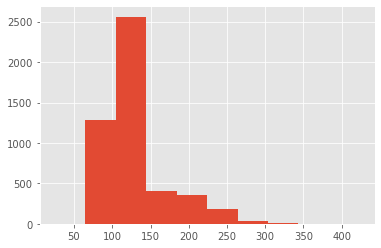

In [122]:
format_df_final['potencia'].hist()

<AxesSubplot:>

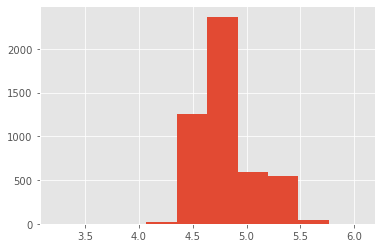

In [123]:
np.log(format_df_final['potencia']).hist()

<AxesSubplot:>

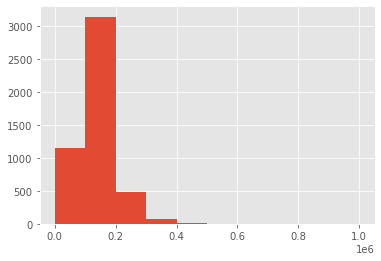

In [124]:
format_df_final['km'].hist()

<AxesSubplot:>

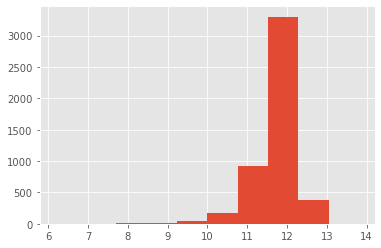

In [125]:
np.log(format_df_final['km']).hist()

<AxesSubplot:>

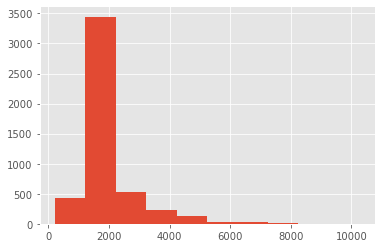

In [126]:
format_df_final['dias_venta_registro'].hist()

<AxesSubplot:>

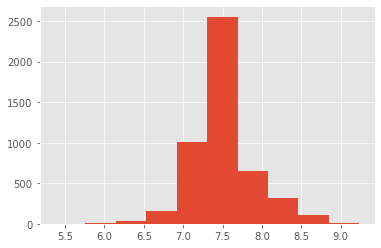

In [127]:
np.log(format_df_final['dias_venta_registro']).hist()

<AxesSubplot:>

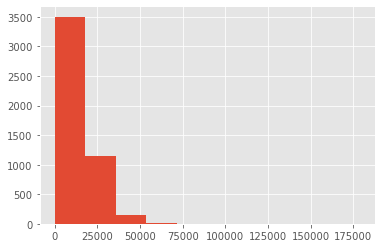

In [128]:
# La del target es una distribución totalmente tirada a la izquierda (left-skewed)
format_df_final[target].hist()

<AxesSubplot:>

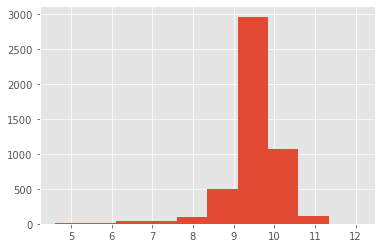

In [129]:
# Con un log se normaliza
np.log(format_df_final[target]).hist()

In [130]:
# Se genera la columna del logaritmo para el target
format_df_final['log_' + target] = np.log(format_df_final[target])

Ya se tiene todo el dataset con columnas numéricas y sin nulos. Ahora toca generar el modelo!

## Model Generation

### Partición train/test/val

In [131]:
# Se trabajará con el target log_precio, así que se elimina el precio del dataset
format_df_final.drop(columns = target, inplace = True)
target = 'log_precio'

Se supone que los coches que más se venden son los que tienen un kilometraje menor. Es por eso que en la partición de validación se cojeran los coches con un km más bajo. Se comprobará que en cuanto a tipos de coche la muestra de validación también tenga todos los tipos. Se buscará una partición de validación del 10%, ya que tenemos una muestra global muy pequeña

In [132]:
# 10% de datos con el kilometraje más bajo
cuantil_km = np.quantile(format_df['km'], 0.10)

In [133]:
# Se genera el dataframe con estas muestras
sub_km_df = format_df[format_df['km'] < cuantil_km]

In [134]:
# Se comprueba que existen coches de todos los tipos
pd.concat([sub_km_df['tipo_coche'].value_counts(), format_df['tipo_coche'].value_counts()], axis = 1)

,tipo_coche,tipo_coche
suv,134,1058
hatchback,122,703
sedan,79,1168
estate,61,1602
coupe,35,103
van,21,43
subcompact,20,113
convertible,12,47


In [135]:
dev_df = format_df_final.drop(sub_km_df.index)
val_df = format_df_final.loc[sub_km_df.index]

In [136]:
dev_df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4353 entries, 0 to 4836
Columns: 95 entries, km to log_precio
dtypes: float64(3), int32(89), int64(3)
memory usage: 1.7 MB


In [137]:
val_df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 1 to 4835
Columns: 95 entries, km to log_precio
dtypes: float64(3), int32(89), int64(3)
memory usage: 194.7 KB


In [138]:
# Se extraen variables X e y
val_df_X = val_df.drop(target, axis=1)
val_df_y = val_df[[target]]
dev_df_X = dev_df.drop(target, axis=1)
dev_df_y = dev_df[[target]]

In [139]:
val_df_X.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 1 to 4835
Columns: 94 entries, km to sub_modelo_Gran Tourer
dtypes: float64(2), int32(89), int64(3)
memory usage: 191.0 KB


In [140]:
val_df_y.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 1 to 4835
Columns: 1 entries, log_precio to log_precio
dtypes: float64(1)
memory usage: 7.6 KB


In [141]:
dev_df_X.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4353 entries, 0 to 4836
Columns: 94 entries, km to sub_modelo_Gran Tourer
dtypes: float64(2), int32(89), int64(3)
memory usage: 1.7 MB


In [142]:
dev_df_y.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4353 entries, 0 to 4836
Columns: 1 entries, log_precio to log_precio
dtypes: float64(1)
memory usage: 68.0 KB


In [143]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dev_df_X,
    dev_df_y,
    random_state = 23,
    test_size = 0.15
)

In [144]:
X_train.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3700 entries, 778 to 662
Columns: 94 entries, km to sub_modelo_Gran Tourer
dtypes: float64(2), int32(89), int64(3)
memory usage: 1.4 MB


In [145]:
y_train.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3700 entries, 778 to 662
Columns: 1 entries, log_precio to log_precio
dtypes: float64(1)
memory usage: 57.8 KB


In [146]:
X_test.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 1774 to 1070
Columns: 94 entries, km to sub_modelo_Gran Tourer
dtypes: float64(2), int32(89), int64(3)
memory usage: 257.6 KB


In [147]:
y_test.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 1774 to 1070
Columns: 1 entries, log_precio to log_precio
dtypes: float64(1)
memory usage: 10.2 KB


### Modelo de regresión lineal simple

In [148]:
# Se inicia un modelo de regressión lineal clásico
modelo_lineal = LinearRegression()

In [149]:
modelo_lineal.fit(X_train, y_train)

LinearRegression()

In [183]:
# Se genera una tabla resumen de la predicción y los errores, así como el cálculo del MSE y RMSE
def tabla_prediccion(model, X_test, y_test):
    prediccion_df = pd.DataFrame(model.predict(X_test), columns = ['prediccion_' + target])
    prediccion_df = prediccion_df.join(y_test.reset_index(drop = True))
    prediccion_df['error'] = prediccion_df[target] - prediccion_df['prediccion_' + target]
    prediccion_df['square_error'] = prediccion_df['error'] ** 2
    mse = prediccion_df['square_error'].mean()
    rmse = np.sqrt(prediccion_df['square_error'].mean())
    display(prediccion_df.head())
    print(f'MSE: {mse}\nRMSE: {rmse}')
    return prediccion_df, mse, rmse


In [184]:
results_df, mse, rmse = tabla_prediccion(modelo_lineal, X_test, y_test)

,prediccion_log_precio,log_precio,error,square_error
0,9.601900,9.495519,-0.106381,0.011317
1,9.343413,9.296518,-0.046894,0.002199
2,9.173714,9.287301,0.113587,0.012902
3,9.639354,9.705037,0.065683,0.004314
4,10.016389,9.957028,-0.059361,0.003524


MSE: 0.1750208245584382
RMSE: 0.4183549026346389


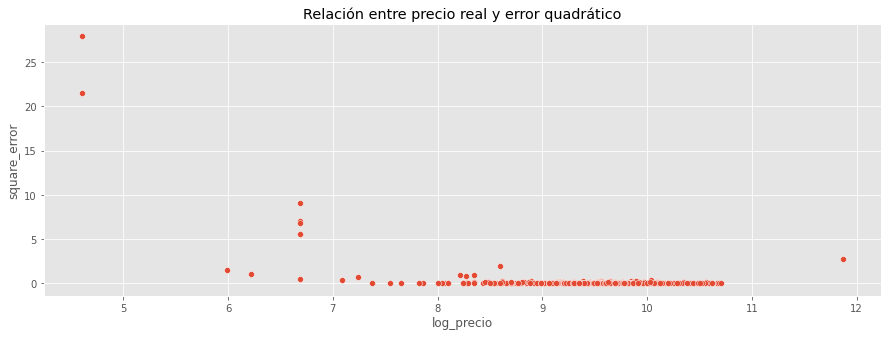

In [190]:
# Parece que el modelo predice mal los coches baratos, pero precide bien los coches caros
plt.figure(figsize = (15,5));
sns.scatterplot(x = 'log_precio', y = 'square_error', data = results_df);
plt.title('Relación entre precio real y error quadrático');

Parece que el modelo funciona bastante bien, excepto en los coches más baratos y el más caro (outliers). Se pasa el modelo a validación

In [187]:
results_df_val, mse_val, rmse_val = tabla_prediccion(modelo_lineal, val_df_X, val_df_y)

,prediccion_log_precio,log_precio,error,square_error
0,11.161911,11.151956,-0.009955,0.000099
1,10.152258,9.994242,-0.158016,0.024969
2,9.770248,9.126959,-0.643289,0.413821
3,9.469362,10.341742,0.872381,0.761048
4,10.446605,10.056209,-0.390396,0.152409


MSE: 0.08371464697401142
RMSE: 0.2893348353966584


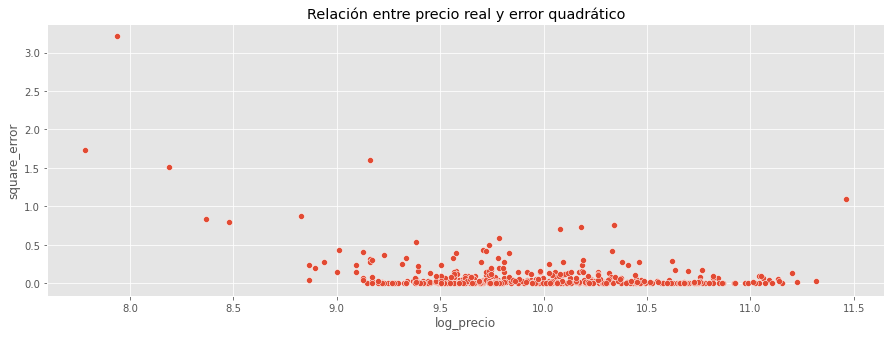

In [189]:
plt.figure(figsize = (15,5));
sns.scatterplot(x = 'log_precio', y = 'square_error', data = results_df_val);
plt.title('Relación entre precio real y error quadrático');
plt.show()

El modelo parece que funciona incluso mejor en validación (no tiene estos outliers tan marcados de precio).
De todas maneras, a continuación se prueban estrategias de normalizar distribuciones de variables numéricas para ver si el modelo funciona mejor